# AirBnB Data Analysis: Modelling & Inference

In the current repository, I will analyze the [AirBnB dataset from the Basque Country / Euskadi](http://insideairbnb.com/get-the-data/). The [Basque Country](https://en.wikipedia.org/wiki/Basque_Country_(autonomous_community)) is the region from Spain I am from; after many years living in Germany, I moved back here in 2020. As a popular touristic target on the seaside, the analysis might be valuable for many visitors :-)

The first notebook `00_AirBnB_DataAnalysis_Initial_Tests.ipynb` has defined the main business questions, related to:

1. Most important features for price prediction (= target)
2. Difference in features between the two most important cities: Donostia-San Sebastian & Bilbao
3. Difference in features between cities with beach access and without
4. EXTRA: Predict review score from review texts

Now, the usual data science process continues:

1. Data cleaning and Preparation
2. Exploratory Data Analysis
3. Feature Engineering
4. Feature Selection
5. **Modelling**
6. **Model Scoring & Inferences**
7. Answering and presenting the Business Questions

The previous notebook `02_AirBnB_DataAnalysis_DataCleaning_EDA.ipynb` has performed the Feature Engineering and Selection.

This notebook focuses on the next two steps: **Modelling** and **Model Scoring & Inference**. The processed train/test splits are loaded here, together with additional files (e.g., scaler, mappings, selected features, etc.).

### Overview of Contents in the Current Notebook

1. Load Dataset & Additional Files

In [750]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# To save the model
import joblib

# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## 1. Load Dataset & Additional Files

In [777]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

In [752]:
scaler = joblib.load(filepath+'minmax_scaler.joblib', mmap_mode='r')

In [753]:
property_types = joblib.load(filepath+'property_types.joblib', mmap_mode='r')

In [754]:
selected_features = joblib.load(filepath+'selected_features.joblib', mmap_mode='r')

In [755]:
numerical_transform_params = joblib.load(filepath+'numerical_transform_params.joblib', mmap_mode='r')

## 2. Model: Linear Regression

### 2.1 Training and Evaluation

#### Select Features

In [756]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

#### Fit Model

In [757]:
#lm = Lasso(alpha=0.001, random_state=0)
lm = Ridge(alpha=0.001, random_state=0)
#lm = LinearRegression()

# Lasso: Train
lm.fit(X_train, y_train)

Ridge(alpha=0.001, random_state=0)

#### Inference

In [758]:
# Lasso: Predictions
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

#### Evaluate

In [759]:
# Train: RMSE, R2
print('Train RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('Train R2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))

print('Test RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

r2_test_lm = np.round(r2_score(np.exp(y_test), np.exp(pred_test)),2)

print('Average listing price: ', int(np.exp(y_train).median()))

Train RMSE: 17
Train R2: 0.3614125847670897
Test RMSE: 14
test r2: 0.35819560526565586

Average listing price:  28


#### Scatterplot: True vs. Predicted

In [760]:
np.exp(y_train).quantile(0.85)

price    49.5
Name: 0.85, dtype: float64

(-10.875, 228.375, -10.875, 228.375)

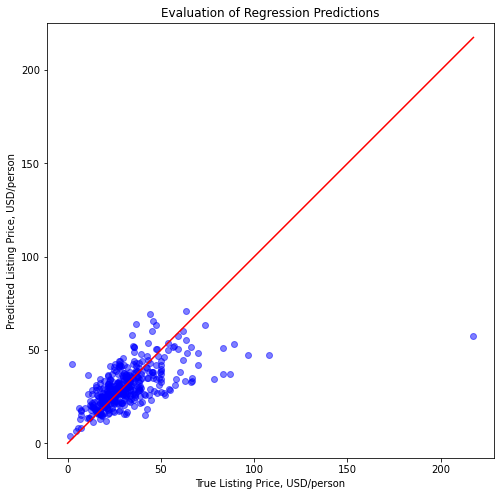

In [761]:
# Real vs. Predicted
# The R2 is only 0.35
# We can see that as the price increases, the prediction error increases
# For large prices the model underpredicts the price.
# That is to be expected, since most of the listings have smaller prices/person
plt.figure(figsize=(8,8))
x = np.exp(y_test)
y_lm = np.exp(lm.predict(X_test))
#x = np.exp(y_train)
#y_lm = np.exp(lm.predict(X_train))
plt.scatter(x, y_lm,color='b',alpha=0.5)
plt.plot(np.array([0,np.max(x)],dtype='object'),np.array([0,np.max(x)],dtype='object'),'r-')
plt.xlabel('True Listing Price, USD/person')
plt.ylabel('Predicted Listing Price, USD/person')
plt.title('Evaluation of Regression Predictions')
plt.axis('equal')

#### Error Histogram

The errors are clearly not normally disturbuted. There are large deviations for low and, specially, for large price values.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

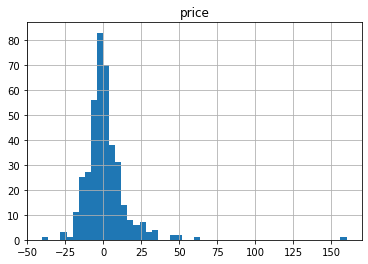

In [762]:
error = x - y_lm
error.hist(bins=50,figsize=(6,4))

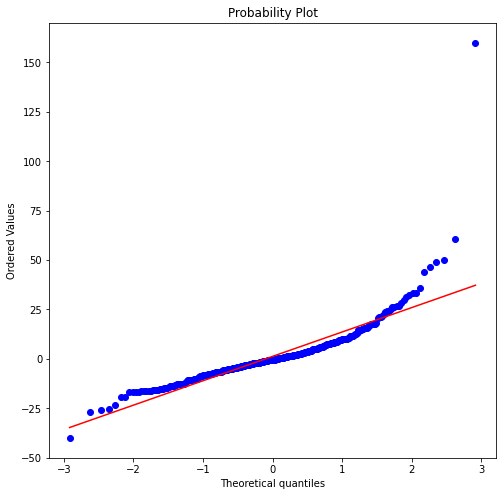

In [763]:
plt.figure(figsize=(8,8))
stats.probplot(error['price'], dist="norm", plot=plt);

### 2.2 Feature Importance

Text(0.5, 1.0, 'Feature Importance')

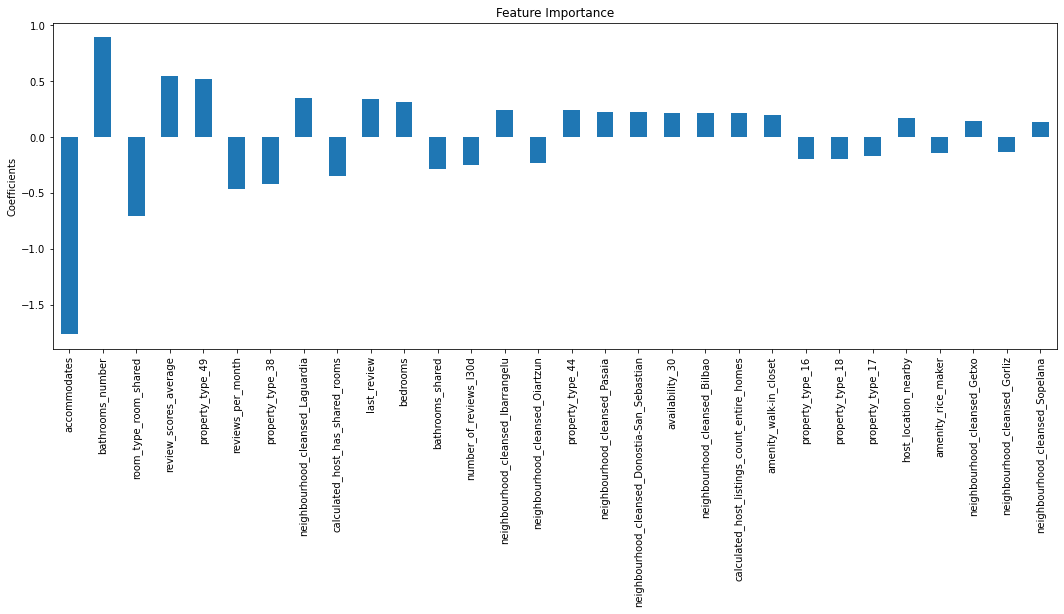

In [764]:
importance_abs = pd.Series(np.abs(lm.coef_.ravel()))
importance = pd.Series(lm.coef_.ravel())
importance_abs.index = selected_features
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)
importance_abs.sort_values(inplace=True, ascending=False)
num_features = 30
imp = importance.loc[importance_abs.iloc[:num_features].index]
#importance_abs.iloc[:30].plot.bar(figsize=(18,6))
imp.plot.bar(figsize=(18,6))
plt.ylabel('Coefficients')
plt.title('Feature Importance')

In [765]:
pd.DataFrame(importance,columns=['importance']).T

,bathrooms_number,review_scores_average,property_type_49,neighbourhood_cleansed_Laguardia,last_review,bedrooms,neighbourhood_cleansed_Ibarrangelu,property_type_44,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Donostia-San_Sebastian,availability_30,neighbourhood_cleansed_Bilbao,calculated_host_listings_count_entire_homes,amenity_walk-in_closet,host_location_nearby,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Sopelana,amenity_indoor_fireplace,host_acceptance_rate,amenity_paid_street_parking_off_premises,property_type_26,amenity_hot_tub,room_type_home,host_response_time_few_days,amenity_beachfront,property_type_51,neighbourhood_group_cleansed_Gipuzkoa,amenity_hair_dryer,amenity_bbq_grill,amenity_lock_on_bedroom_door,neighbourhood_cleansed_Zarautz,amenity_air_conditioning,amenity_sound_system,amenity_dishwasher,amenity_kitchen,amenity_babysitter_recommendations,amenity_nespresso_machine,amenity_outdoor_furniture,amenity_dishes_and_silverware,amenity_backyard,maximum_nights,license_reported,amenity_clothing_storage,number_of_reviews_ltm,amenity_toaster,host_is_superhost,amenity_single_level_home,amenity_carbon_monoxide_alarm,amenity_coffee_maker,amenity_freezer,amenity_beach_essentials,amenity_heating,amenity_breakfast,amenity_outdoor_dining_area,has_beach,amenity_first_aid_kit,amenity_patio_or_balcony,description_language_en,amenity_tv,amenity_hot_water_kettle,amenity_body_soap,amenity_bed_linens,host_response_time_hour,amenity_private_entrance,amenity_pool,amenity_waterfront,amenity_private_patio_or_balcony,amenity_paid_parking_on_premises,amenity_extra_pillows_and_blankets,host_identity_verified,instant_bookable,host_response_time_few_hours,amenity_room-darkening_shades,amenity_cleaning_before_checkout,amenity_shampoo,amenity_hot_water,amenity_microwave,amenity_bathtub,amenity_luggage_dropoff_allowed,amenity_host_greets_you,calculated_host_listings_count_private_rooms,amenity_keypad,amenity_security_cameras_on_property,minimum_nights,amenity_wine_glasses,host_total_listings_count,amenity_paid_parking_off_premises,first_review,property_type_28,amenity_ethernet_connection,amenity_washer,amenity_long_term_stays_allowed,amenity_mini_fridge,amenity_bidet,minimum_minimum_nights,amenity_hangers,amenity_conditioner,amenity_free_street_parking,host_response_time_day,amenity_cooking_basics,neighbourhood_cleansed_Bermeo,calculated_host_listings_count,neighbourhood_group_cleansed_Araba,amenity_drying_rack_for_clothing,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Irun,maximum_minimum_nights,neighbourhood_cleansed_Gorliz,amenity_rice_maker,property_type_17,property_type_18,property_type_16,neighbourhood_cleansed_Oiartzun,number_of_reviews_l30d,bathrooms_shared,calculated_host_has_shared_rooms,property_type_38,reviews_per_month,room_type_room_shared,accommodates
importance,0.890024,0.54851,0.519882,0.350464,0.334489,0.312439,0.237579,0.236513,0.225146,0.222055,0.217568,0.210237,0.209961,0.197814,0.165326,0.141624,0.133116,0.115045,0.106693,0.106437,0.102647,0.102142,0.100831,0.100429,0.097331,0.095166,0.087498,0.08653,0.08076,0.078777,0.074536,0.06983,0.062307,0.058747,0.056974,0.055425,0.05423,0.052662,0.050883,0.049607,0.047052,0.046225,0.042902,0.040022,0.03846,0.038331,0.03757,0.036268,0.034779,0.034599,0.029399,0.028123,0.027884,0.02641,0.024485,0.024196,0.023295,0.018823,0.018235,0.018227,0.01749,0.017047,0.013277,0.012548,0.011493,0.010841,0.00624,-0.008117,-0.012422,-0.0147,-0.019373,-0.019685,-0.022569,-0.023229,-0.026228,-0.026447,-0.026574,-0.027492,-0.030454,-0.030734,-0.032571,-0.03721,-0.038943,-0.040332,-0.040641,-0.040914,-0.042644,-0.042706,-0.046511,-0.049348,-0.052081,-0.052145,-0.057796,-0.060372,-0.062822,-0.063067,-0.063136,-0.091947,-0.094021,-0.09667,-0.101918,-0.113998,-0.114642,-0.115258,-0.118917,-0.129558,-0.13108,-0.134617,-0.143047,-0.173371,-0.197118,-0.197247,-0.237189,-0.253465,-0.28554,-0.347735,-0.418449,-0.463492,-0.709387,-1.761588


In [766]:
property_types['index2name'][21]

'Private room in guesthouse'

## 3. Model: Random Forests

Since the linear regression model performs so poorly, we try random forests, since often outperform many other models when dealing with tabular data.

### 3.1 Training and Evaluation

#### Select Features and Fit Model

In [767]:
from sklearn.ensemble import RandomForestRegressor

# Select features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Create model & fit
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, np.ravel(y_train))

RandomForestRegressor(random_state=0)

#### Inference

In [768]:
#Predictions
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

#### Evaluations

In [769]:
# Train: RMSE, R2
print('Train RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('Train R2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))

print('Test RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

r2_test_rf = np.round(r2_score(np.exp(y_test), np.exp(pred_test)),2)

print('Average listing price: ', int(np.exp(y_train).median()))

Train RMSE: 8
Train R2: 0.8297215180352486
Test RMSE: 11
test r2: 0.5775175180079398

Average listing price:  28


#### Scatterplot: True vs. Predicted

(-10.875, 228.375, -10.875, 228.375)

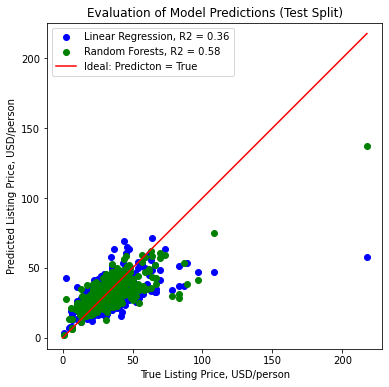

In [772]:
# Real vs. Predicted
# The R2 is only 0.57
# We can see that as the price increases, the prediction error increases
# as heppened with the linear regression model
# However, the prediction and true points are closer to the ideal line
plt.figure(figsize=(6,6))
x = np.exp(y_test)
y_rf = np.exp(rf.predict(X_test))
#x = np.exp(y_train)
#y_rf = np.exp(rf.predict(X_train))
plt.scatter(x, y_lm,color='b',alpha=1.0)
plt.scatter(x, y_rf,color='g',alpha=1.0)
plt.plot(np.array([0,np.max(x)],dtype='object'),np.array([0,np.max(x)],dtype='object'),'r-')
plt.legend([f'Linear Regression, R2 = {r2_test_lm}',f'Random Forests, R2 = {r2_test_rf}','Ideal: Predicton = True'])
plt.xlabel('True Listing Price, USD/person')
plt.ylabel('Predicted Listing Price, USD/person')
plt.title('Evaluation of Model Predictions (Test Split)')
plt.axis('equal')

#### Error Histogram

In [744]:
x.shape, y.shape

((394, 1), (201, 1))

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

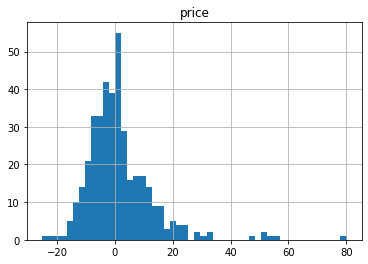

In [745]:
error = x - y_rf.reshape(-1,1)
error.hist(bins=50,figsize=(6,4))

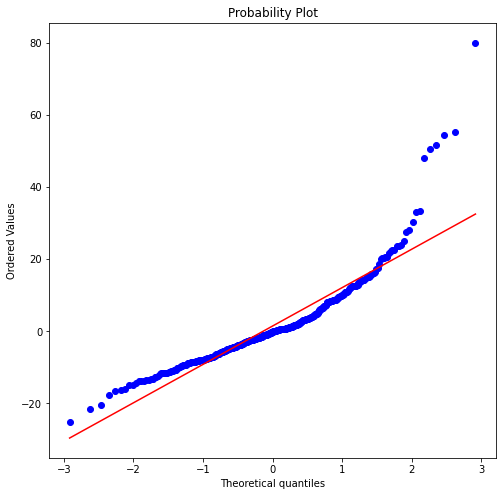

In [746]:
plt.figure(figsize=(8,8))
stats.probplot(error['price'], dist="norm", plot=plt);

### 3.2 Feature Importance

Text(0.5, 1.0, 'Feature Importance - Accumulated Gini 69.0 %')

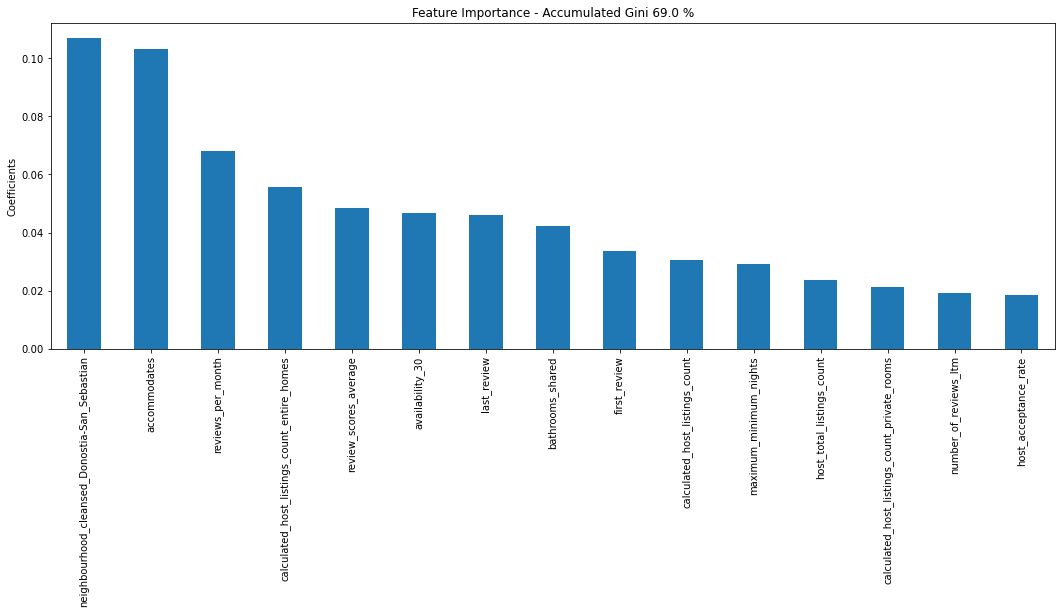

In [793]:
importance = pd.Series(rf.feature_importances_.ravel())
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)
top_features = 15
importance.iloc[:top_features].plot.bar(figsize=(18,6))
gini_sum = 0
gini_importances = np.array(importance.iloc[:top_features])
for gini in gini_importances:
    gini_sum += gini
plt.ylabel('Coefficients')
plt.title(f'Feature Importance - Accumulated Gini {np.round(gini_sum,2)*100} %')

In [797]:
importance

neighbourhood_cleansed_Donostia-San_Sebastian    0.106984
accommodates                                     0.103231
reviews_per_month                                0.067943
calculated_host_listings_count_entire_homes      0.055803
review_scores_average                            0.048551
                                                   ...   
amenity_walk-in_closet                           0.000218
neighbourhood_cleansed_Gorliz                    0.000150
amenity_rice_maker                               0.000149
neighbourhood_cleansed_Laguardia                 0.000065
property_type_38                                 0.000026
Length: 120, dtype: float64

### 3.3 Computation of Bargains

Bargains are listings which are predicted to have higher prices than the actual ones. Given the low R2 value, the selection of those listings is not that trustworthy, though.

In [703]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

X_all = pd.concat([X_train,X_test],axis=0).reset_index(drop=True)
y_all = pd.concat([y_train,y_test],axis=0).reset_index(drop=True)

X_all.shape, y_all.shape

((3931, 353), (3931, 1))

In [704]:
y = np.exp(y_all).reset_index(drop=True)
y_pred = np.exp(rf.predict(X_all[selected_features]))
y_pred = pd.DataFrame(y_pred,columns=['price']).reset_index(drop=True)

In [705]:
indices = y<y_pred

In [706]:
indices

,price
0,False
1,True
2,False
3,True
4,True
...,...
3926,False
3927,False
3928,False
3929,True


In [707]:
X = X_all.loc[indices.values]
y = y.loc[indices.values]
y_pred = y_pred.loc[indices.values]

In [708]:
threshold_price = y.quantile(0.9)
threshold_score = X['review_scores_average'].quantile(0.9)

In [709]:
indices = X.review_scores_average > threshold_score
indices
X = X[indices.values]
y = y[indices.values]
y_pred = y_pred[indices.values]
X.head()

,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Amurrio,neighbourhood_cleansed_Asteasu,neighbourhood_cleansed_Astigarraga,neighbourhood_cleansed_Azkoitia,neighbourhood_cleansed_Azpeitia,neighbourhood_cleansed_Bakio,neighbourhood_cleansed_Barakaldo,neighbourhood_cleansed_Bermeo,neighbourhood_cleansed_Bilbao,neighbourhood_cleansed_Busturia,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Durango,neighbourhood_cleansed_Ea,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Elciego,neighbourhood_cleansed_Errenteria,neighbourhood_cleansed_Gautegiz Arteaga,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Getaria,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,neighbourhood_cleansed_Hernani,neighbourhood_cleansed_Hondarribia,neighbourhood_cleansed_Ibarrangelu,neighbourhood_cleansed_Irun,neighbourhood_cleansed_Karrantza Harana,neighbourhood_cleansed_Labastida,neighbourhood_cleansed_Laguardia,neighbourhood_cleansed_Lanciego,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Leioa,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Markina-Xemein,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Mundaka,neighbourhood_cleansed_Mungia,neighbourhood_cleansed_Mutriku,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Orio,neighbourhood_cleansed_Ortuella,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Plentzia,neighbourhood_cleansed_Portugalete,neighbourhood_cleansed_Samaniego,neighbourhood_cleansed_Santurtzi,neighbourhood_cleansed_Segura,neighbourhood_cleansed_Sestao,neighbourhood_cleansed_Sopelana,neighbourhood_cleansed_Sopuerta,neighbourhood_cleansed_Urduna-Orduna,neighbourhood_cleansed_Urnieta,neighbourhood_cleansed_Valdegovia,neighbourhood_cleansed_Vitoria-Gasteiz,neighbourhood_cleansed_Zarautz,neighbourhood_cleansed_Zuia,neighbourhood_cleansed_Zumaia,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,property_type_17,property_type_18,property_type_19,property_type_20,property_type_21,property_type_22,property_type_23,property_type_24,property_type_25,property_type_26,property_type_27,property_type_28,property_type_29,property_type_30,property_type_31,property_type_32,property_type_33,property_type_34,property_type_35,property_type_36,property_type_37,property_type_38,property_type_39,property_type_40,property_type_41,property_type_42,property_type_43,property_type_44,property_type_45,property_type_46,property_type_47,property_type_48,property_type_49,property

In [710]:
X.shape, y.shape

((201, 353), (201, 1))

In [711]:
pd.DataFrame(X.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352
0,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_location_nearby,has_beach,license_reported,host_since,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bathrooms_private,bathrooms_shared,calculated_host_has_shared_rooms,neighbourhood_group_cleansed_Araba,neighbourhood_group_cleansed_Bizkaia,neighbourhood_group_cleansed_Gipuzkoa,host_response_time_day,host_response_time_few_days,host_response_time_few_hours,host_response_time_hour,description_language_en,description_language_es,description_language_fr,description_language_other,room_type_home,room_type_room_hotel,room_type_room_private,room_type_room_shared,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Amurrio,neighbourhood_cleansed_Asteasu,neighbourhood_cleansed_Astigarraga,neighbourhood_cleansed_Azkoitia,neighbourhood_cleansed_Azpeitia,neighbourhood_cleansed_Bakio,neighbourhood_cleansed_Barakaldo,neighbourhood_cleansed_Bermeo,neighbourhood_cleansed_Bilbao,neighbourhood_cleansed_Busturia,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Durango,neighbourhood_cleansed_Ea,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Elciego,neighbourhood_cleansed_Errenteria,neighbourhood_cleansed_Gautegiz Arteaga,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Getaria,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,neighbourhood_cleansed_Hernani,neighbourhood_cleansed_Hondarribia,neighbourhood_cleansed_Ibarrangelu,neighbourhood_cleansed_Irun,neighbourhood_cleansed_Karrantza Harana,neighbourhood_cleansed_Labastida,neighbourhood_cleansed_Laguardia,neighbourhood_cleansed_Lanciego,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Leioa,neighbourhood_cleansed_Lekeitio,neighbourhood_cleansed_Markina-Xemein,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Mundaka,neighbourhood_cleansed_Mungia,neighbourhood_cleansed_Mutriku,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Orio,neighbourhood_cleansed_Ortuella,neighbourhood_cleansed_Pasaia,neighbourhood_c

In [773]:
data = pd.concat([X,y],axis=1)

In [774]:
latitude = scaler.inverse_transform(X)[:,18]
longitude = scaler.inverse_transform(X)[:,19]
data['latitude'] = latitude
data['longitude'] = longitude

In [775]:
data_all = pd.concat([X_all,y_all],axis=1)
latitude = scaler.inverse_transform(X_all)[:,18]
longitude = scaler.inverse_transform(X_all)[:,19]
data_all['latitude'] = latitude
data_all['longitude'] = longitude

<AxesSubplot:title={'center':'201/3931 economic and good quality (90% quantile) listings detected, in red'}, xlabel='longitude', ylabel='latitude'>

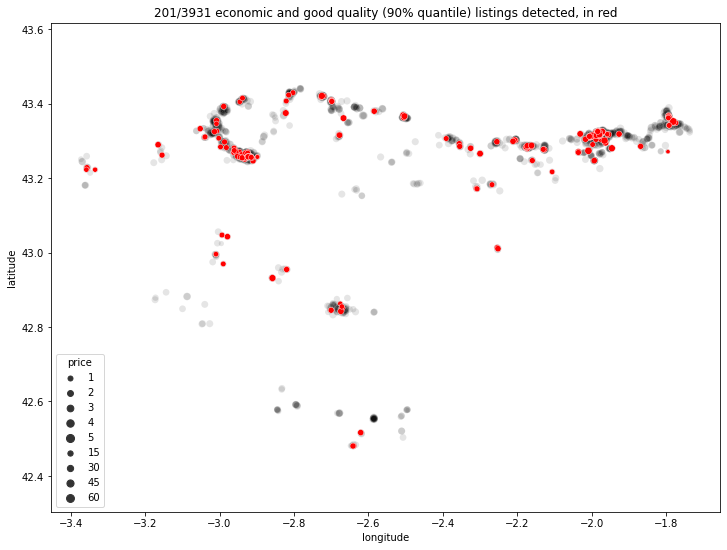

In [776]:
# Property coordinates and their prices enconded with color
# Only properties with access to a beach (< 2km) are considered
#df.plot.scatter(x='longitude',y='latitude',c='price',cmap='coolwarm',figsize=(12,8.5))
plt.figure(figsize=(12,9))
plt.axis('equal')
plt.title(f'{data.shape[0]}/{data_.shape[0]} economic and good quality (90% quantile) listings detected, in red')
#sns.scatterplot(data=data,x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
sns.scatterplot(data=data_all,x='longitude',y='latitude',color='black',size='price',alpha=0.1)
sns.scatterplot(data=data,x='longitude',y='latitude',color='red',size='price')
#plt.legend(loc='lower right',title='Price, USD/person')

## 4. Comparing Listings Depending on Key Values

In [799]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

X_all = pd.concat([X_train,X_test],axis=0).reset_index(drop=True)
y_all = pd.concat([y_train,y_test],axis=0).reset_index(drop=True)

X_all.shape, y_all.shape

data = pd.concat([X_all,y_all],axis=1).reset_index(drop=True)

In [802]:
# Example: Filter listings from Donostia-San Sebastian and check number of values of a feature
X_all[X_all['neighbourhood_cleansed_Donostia-San_Sebastian'] > 0]['room_type_home'].value_counts()

1.0    986
0.0    306
Name: room_type_home, dtype: int64

In [801]:
# Example: Filter listings from Donostia-San Sebastian and check number of values of a feature
y_all[X_all['has_beach'] > 0].value_counts()

price   
3.218876    86
3.401197    69
2.995732    54
3.912023    52
3.624341    42
            ..
3.151667     1
3.824284     1
3.152736     1
3.820456     1
5.703782     1
Length: 635, dtype: int64